# **Final Assignment - Semantic Segmentation**

Objective: Implement a U-Net Network for Semantic Segmentation

Dataset: ISPRS 2D Semantic Labeling Challenge (Vaihingen)

<figure>
<center>
<img src= 'https://drive.google.com/uc?export=view&id=19wmyEXtnTV8gMOn02FPeJ8JcVSKVOycH'/>
</figure>

In the code below the network was trained only with image Train1.

In the assignment you should use both Train1 and Train2 images to train. 

Notice that you will have to adapt the so that the network will take as imput an image concatenated with its DSM.




# **1. Import libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import ogr, gdal

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, Dropout, concatenate, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# **2. Defining root folder**

In [47]:
%cd /content/drive/MyDrive/estudo_dirigido/modelos

/content/drive/MyDrive/estudo_dirigido/modelos


In [48]:
!ls

In [49]:
!pwd

/content/drive/MyDrive/estudo_dirigido/modelos


In [50]:
print(root_path)

/content/drive/My Drive/estudo_dirigido/notebooks


In [2]:
# root_path will be used to store trained models

from google.colab import drive
# mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# adjust the path to the location where the models will be written / read
root_path = '/content/drive/MyDrive/estudo_dirigido/modelos/'

Mounted at /content/drive


# **3. Loading the data**

In [3]:
# Downloading the dataset and unpacking it.
# 6 files: Test_Image.tif, Test_DSM.tif, Test_Reference.tif, Train1_Image.tif, Train1_DSM.tif, Train1_Reference.tif, Train2_Image.tif, Train2_DSM.tif, Train2_Reference.tif

!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part1.rar
!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part2.rar
!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part3.rar
!unrar e Images_Semantic_Segmentatio_Assignment.part1.rar


--2022-01-15 01:53:22--  https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part1.rar
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gilson-costa/files/main/Images_Semantic_Segmentatio_Assignment.part1.rar [following]
--2022-01-15 01:53:22--  https://raw.githubusercontent.com/gilson-costa/files/main/Images_Semantic_Segmentatio_Assignment.part1.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25165824 (24M) [application/octet-stream]
Saving to: ‘Images_Semantic_Segmentatio_Assignment.part1.rar’

Images_Semantic_Seg 100%[===================>]  24.00M  --.-KB/

In [4]:
# Listing the contents of the virtual machine.
!ls -l

total 226228
drwx------ 5 root root     4096 Jan 15 01:53 drive
-rw-r--r-- 1 root root 25165824 Jan 15 01:53 Images_Semantic_Segmentatio_Assignment.part1.rar
-rw-r--r-- 1 root root 25165824 Jan 15 01:53 Images_Semantic_Segmentatio_Assignment.part2.rar
-rw-r--r-- 1 root root  9414015 Jan 15 01:53 Images_Semantic_Segmentatio_Assignment.part3.rar
drwxr-xr-x 1 root root     4096 Jan  7 14:33 sample_data
-rw-r--r-- 1 root root 28852100 Aug 19  2014 Test_DSM.tif
-rw-r--r-- 1 root root 21789756 Nov  1  2013 Test_Image.tif
-rw-r--r-- 1 root root 22326104 Apr 28  2014 Test_Reference.tif
-rw-r--r-- 1 root root 19707152 Aug 19  2014 Train1_DSM.tif
-rw-r--r-- 1 root root 14870332 Nov  1  2013 Train1_Image.tif
-rw-r--r-- 1 root root 15259952 Apr 28  2014 Train1_Reference.tif
-rw-r--r-- 1 root root 19398356 Aug 19  2014 Train2_DSM.tif
-rw-r--r-- 1 root root 14643100 Nov  1  2013 Train2_Image.tif
-rw-r--r-- 1 root root 15036852 Apr 28  2014 Train2_Reference.tif


In [5]:
# Functions

def load_tiff_image(image):
  print (image)
  gdal_header = gdal.Open(image)
  img_gdal = gdal_header.ReadAsArray()
  img = np.transpose(img_gdal, (1,2,0))
  return img

def normalization(image):
  image_reshaped = image.reshape((image.shape[0]*image.shape[1]),image.shape[2])
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler = scaler.fit(image_reshaped)
  image_normalized_ = scaler.fit_transform(image_reshaped)
  image_normalized = image_normalized_.reshape(image.shape[0],image.shape[1],image.shape[2])
  return image_normalized

In [6]:
# Loading and normalizing images

reference_train = load_tiff_image('Train1_Reference.tif')
print(reference_train.shape)
image_train = load_tiff_image('Train1_Image.tif')
# Normalizes training image (pixel values from 0 to 1)
image_train = normalization(image_train)
print(image_train.shape)

reference_test = load_tiff_image('Test_Reference.tif')
print(reference_test.shape)
image_test = load_tiff_image('Test_Image.tif')
# Normalizes testing image (pixel values from 0 to 1)
image_test = normalization(image_test)
print(image_test.shape)


Train1_Reference.tif
(2565, 1919, 3)
Train1_Image.tif
(2565, 1919, 3)
Test_Reference.tif
(2558, 2818, 3)
Test_Image.tif
(2558, 2818, 3)


# **4. Creating labeled images from references**

In [7]:
# Defining number of classes and class indices in relation to reference images (RGB)

num_classes = 6
color2label = {
    (255, 255, 255) : 0,  # Impervious surfaces
    (0,   255, 255) : 1,  # Low vegetation
    (0,     0, 255) : 2,  # Building
    (0,   255,   0) : 3,  # Tree
    (255, 255,   0) : 4   # Car
}

def create_label_image(rgb_image):
  W = np.power(256, [[0],[1],[2]])
  img_index = rgb_image.dot(W).squeeze(-1) 
  values = np.unique(img_index)
  label_image = np.zeros(img_index.shape)
  for i, c in enumerate(values):
    try:
      label_image[img_index==c] = color2label[tuple(rgb_image[img_index==c][0])] 
    except:
      pass
  return label_image

In [8]:
# Tranforming regerence RGB images into label images

labels_train = create_label_image(reference_train)
print(labels_train.shape)
labels_test = create_label_image(reference_test)
print(labels_test.shape)

(2565, 1919)
(2558, 2818)



Plotting images...


(-0.5, 2817.5, 2557.5, -0.5)

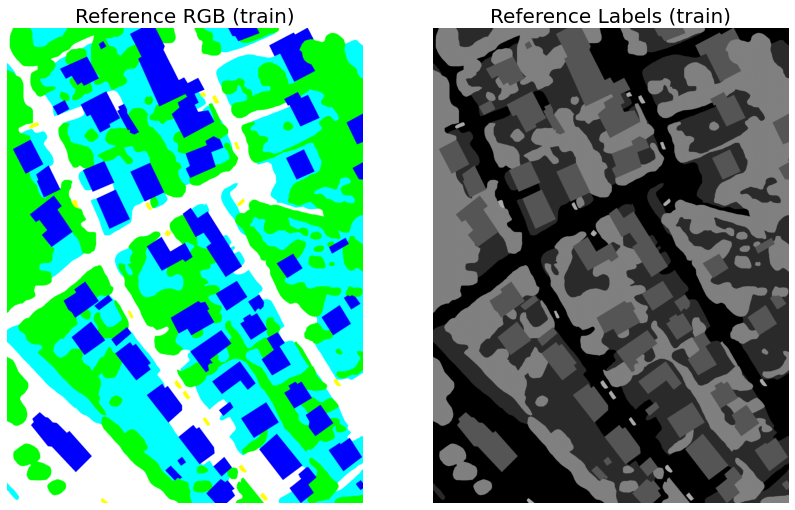

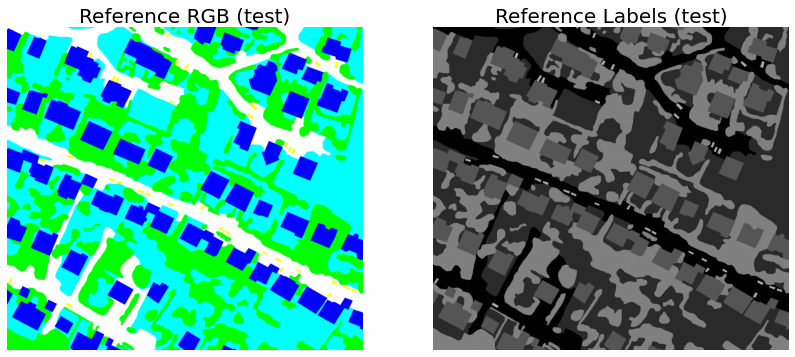

In [9]:
# Inspecting label images (train and test)

print('\nPlotting images...')

fig1, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow( reference_train )
ax1.set_title('Reference RGB (train)', fontsize=20)
ax1.axis('off')
ax2.imshow( labels_train, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference Labels (train)', fontsize=20)
ax2.axis('off')

fig2, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow( reference_test )
ax1.set_title('Reference RGB (test)', fontsize=20)
ax1.axis('off')
ax2.imshow( labels_test, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference Labels (test)', fontsize=20)
ax2.axis('off')

# **5. Extracting image patches for training**

In [10]:
# Constants and functions

# patch_size defines the measures (spatial dimensions) of the patch.
# Working with square patches (H = W). Therefore, a scalar variable is enough.
patch_size = 256

# patch_stride determine the position of the next patch.
# A patch_stride smaller than the spatial dimension of the patch determines an overlapping.
# 25% ​​overlap between patches.
patch_stride = patch_size - (patch_size // 4)

# channels of the image/patches to be segmented
image_channels = 3

# shape of the input to the network (training)
input_shape = (patch_size, patch_size, image_channels)

# Function: extract_patches
# -------------------------
# Extract patches from the original and reference image
#
# Input parameters:
#   image      = array containing the original image (h,w,c)
#   reference  = array containing the reference image (h,w,c)
#   patch_size = patch size (scalar). The shape of the patch is square.
#   stride     = displacement to be applied.
#   border_patches = include patches overlaping image borders
#
# Returns: 
#   A, B = List containing the patches for the input image (A) and respective reference (B).
#
def extract_patches(image, reference, patch_size, stride, border_patches=False):
    print("Image dimensions:", image.shape)
    print("Reference dimensions:", reference.shape)

    patch_img = []
    patch_ref = []

    h = image.shape[0] // stride
    w = image.shape[1] // stride

    for m in range(0, h):
        for n in range(0, w):
            #print('M %d, N %d, start %d finish %d , start %d finish %d' % (m, n, m*stride , m*stride+patch_size, n*stride, n*stride+patch_size) )
            if ( (m*stride+patch_size <= image.shape[0]) and (n*stride+patch_size <= image.shape[1]) ):
                patch_img.append( image[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size,:] )
                patch_ref.append( reference[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size] )
            elif border_patches:
                border_patch_img = np.zeros((patch_size,patch_size,image_channels))
                border_patch_ref = np.zeros((patch_size,patch_size))
                if (m*stride+patch_size > image.shape[0]):
                  border_mmax = patch_size-(m*stride+patch_size-image.shape[0])
                else:
                  border_mmax = patch_size-1
                if (n*stride+patch_size > image.shape[1]):
                  border_nmax = patch_size-(n*stride+patch_size-image.shape[1])
                else:
                  border_nmax = patch_size-1

                border_patch_img[0:border_mmax,0:border_nmax,:] = image[m*stride:m*stride+border_mmax,n*stride:n*stride+border_nmax,:]
                border_patch_ref[0:border_mmax,0:border_nmax] = reference[m*stride:m*stride+border_mmax,n*stride:n*stride+border_nmax]
                patch_img.append( border_patch_img )
                patch_ref.append( border_patch_ref )
       
    return np.array(patch_img), np.array(patch_ref)


In [11]:
# Extracting training patches

x_patches, y_patches = extract_patches(image_train, labels_train, patch_size, patch_stride)

# Transform y_patches, shape (N, H, W) into shape (N, H, W, C). Necessary for data agumentation.
y_patches = np.expand_dims(y_patches, 3)

print( "Number of patches: %d %s " % ( x_patches.shape[0], x_patches.shape[1:] ) )
print( "Number of labeled references: %d %s " % ( y_patches.shape[0], y_patches.shape[1:] ) )

Image dimensions: (2565, 1919, 3)
Reference dimensions: (2565, 1919)
Number of patches: 117 (256, 256, 3) 
Number of labeled references: 117 (256, 256, 1) 



Plotting images...


(-0.5, 255.5, 255.5, -0.5)

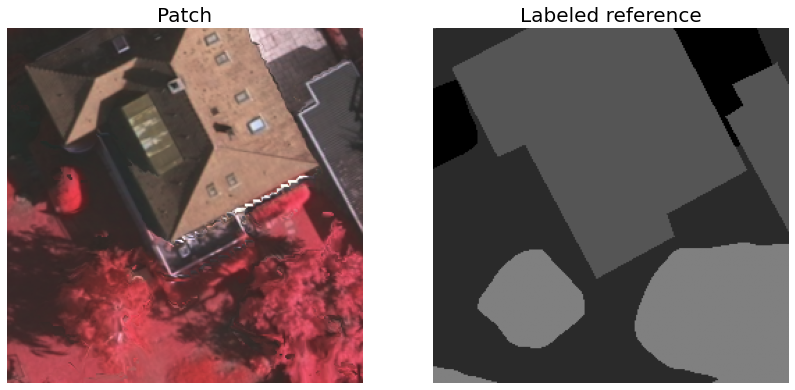

In [12]:
# Inspecting an arbitrary image patch

image_index = 20

print('\nPlotting images...')
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))

ax1.imshow( x_patches[image_index] )
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')
 
ax2.imshow( y_patches[image_index, :, :, 0], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Labeled reference', fontsize=20)
ax2.axis('off')

# **6. Separating training and validation patches**

In [13]:
# Defining the percentage of the training set to be used as validation
valid_percent = 0.2

# Calculating the boundary (index) between training set and validation.
# The premise is always that X and Y have the same number of elements.
limit = len(x_patches) - int( len(x_patches)*valid_percent )

# Building a list of indexes from 0 to N, where N corresponds to the number of images (patches).
indexes = [i for i in range(x_patches.shape[0])]

# Generating randomness in the list
import random
random.shuffle(indexes)

# Indexes of the images that will be used for training
indexes_for_train = indexes[:limit]
# ndexes of the images that will be used for validation
indexes_for_valid = indexes[limit:]

# Training set
x_train = x_patches[indexes_for_train]
y_train = y_patches[indexes_for_train]

# Validation set
x_valid = x_patches[indexes_for_valid]
y_valid = y_patches[indexes_for_valid]

print( "Número de imagens no conjunto de treinamento: %d " % ( len(x_train) ) )
print( "Número de imagens no conjunto de validação: %d " % ( len(x_valid) ) )

# Freeing up memory
x_patches = 0
y_patches = 0

Número de imagens no conjunto de treinamento: 94 
Número de imagens no conjunto de validação: 23 


# **7. Data augmentation**

In [14]:
# Setting data augmentation tranformations and creating data generators

# Only rotations by 90 degrees
def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

# Tranformations for image patches
datagen_args_x = dict(
        # rotation_range=90, # rotation
        # width_shift_range=0.15, # horizontal shift
        # height_shift_range=0.15, # vertical shift
        # zoom_range=0.25, # zoom
        preprocessing_function=orthogonal_rot,
        horizontal_flip=True, # horizontal flip
        vertical_flip=True, # vertical flip
        # brightness_range=[0.8,1.2], # brightness
        fill_mode='constant',
        cval=0
)

# Transformations for reference patches
datagen_args_y = dict(
        # rotation_range=90, # rotation
        # width_shift_range=0.15, # horizontal shift
        # height_shift_range=0.15, # vertical shift
        # zoom_range=0.25, # zoom
        preprocessing_function=orthogonal_rot,
        horizontal_flip=True, # horizontal flip
        vertical_flip=True, # vertical flip
        fill_mode='constant',
        cval=0
)

# Its necessary to provide the same seed and kwargs to the flow method (images and references)
seed = 1
x_datagen = ImageDataGenerator(**datagen_args_x)
y_datagen = ImageDataGenerator(**datagen_args_y)

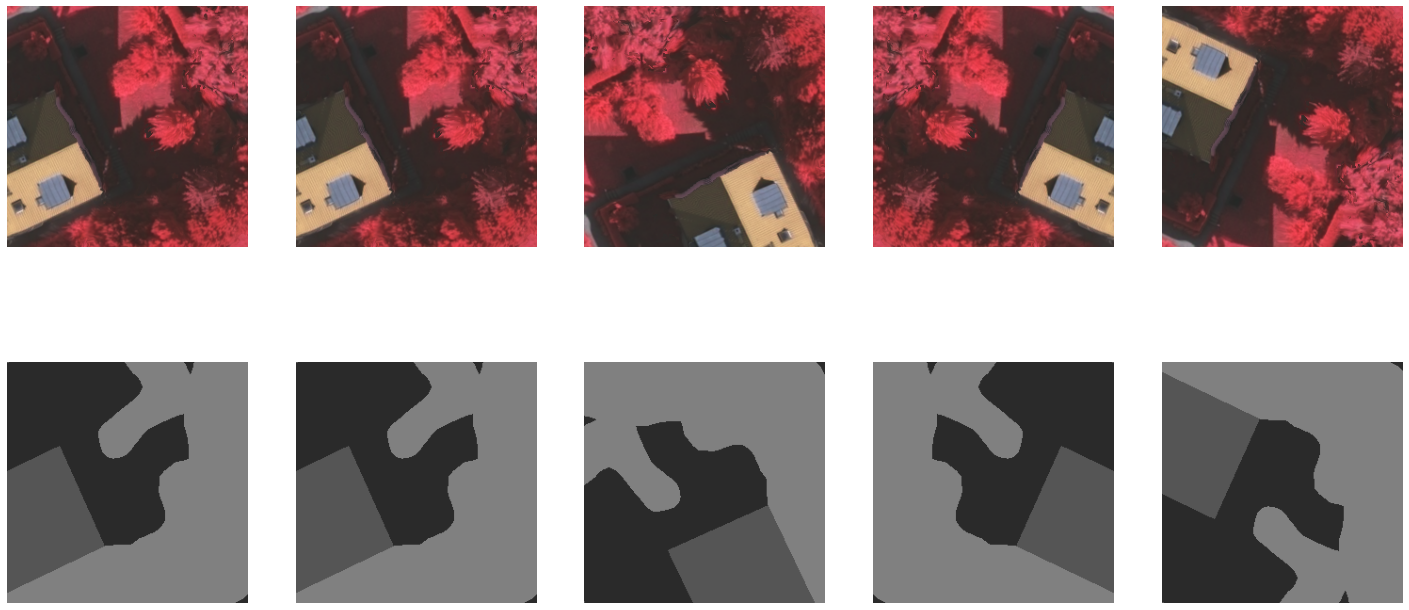

In [15]:
# Example of Data Augmentation for an arbitrary patch

show_index = 25

x_patch = np.expand_dims( x_train[show_index], 0 )
y_patch = np.expand_dims( y_train[show_index], 0 )

x_iterator = x_datagen.flow(x_patch, seed=seed)
y_iterator = y_datagen.flow(y_patch, seed=seed)

data_iterator = next( zip( x_iterator, y_iterator ) )

nrows = 2
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,12))

# generating transformed images
for j in range(ncols):
    data_iterator = next( zip( x_iterator, y_iterator ) )
    ax[0][j].axis('off')
    ax[0][j].imshow(data_iterator[0][0])
    ax[1][j].axis('off')
    ax[1][j].imshow(data_iterator[1][0,:,:,0], cmap='gray', vmin=0, vmax=num_classes )

# **8. Building the CNN model**

In [16]:
# Defining the structure of the CNN

def unet(input_shape, n_classes):
    # Copiado
    # U-Net architecture

    input_img = Input(input_shape)

    # Contract stage
    f1 = 64
    b1conv1 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b1conv1')(input_img)
    b1conv2 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b1conv2')(b1conv1)

    pool1 = MaxPool2D((2 , 2), name = 'pooling1')(b1conv2)

    b2conv1 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b2conv1')(pool1)
    b2conv2 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b2conv2')(b2conv1)

    pool2 = MaxPool2D((2 , 2), name = 'pooling2')(b2conv2)

    b3conv1 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b3conv1')(pool2)
    b3conv2 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b3conv2')(b3conv1)

    pool3 = MaxPool2D((2 , 2), name = 'pooling3')(b3conv2)

    b4conv1 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b4conv1')(pool3)
    b4conv2 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b4conv2')(b4conv1)

    pool4 = MaxPool2D((2 , 2), name = 'pooling4')(b4conv2)

    b5conv1 = Conv2D(f1*16 , (3 , 3) , activation='relu' , padding='same', name = 'b5conv1')(pool4)
    b5conv2 = Conv2D(f1*16 , (3 , 3) , activation='relu' , padding='same', name = 'b5conv2')(b5conv1)

    # Expansion stage
    upsample1 = Conv2DTranspose(f1*8, (3 , 3), strides=(2,2), activation = 'relu', padding = 'same', name = 'upsampling1')(b5conv2)
    concat1 = concatenate( [upsample1,b4conv2] )
    b6conv1 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b6conv1')(concat1)
    b6conv2 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b6conv2')(b6conv1)
    
    upsample2 = Conv2DTranspose(f1*4, (3 , 3), strides=(2,2), activation = 'relu', padding = 'same', name = 'upsampling2')(b6conv2)
    concat2 = concatenate( [upsample2,b3conv2] )
    b7conv1 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b7conv1')(concat2)
    b7conv2 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b7conv2')(b7conv1)

    upsample3 = Conv2DTranspose(f1*2, (3 , 3), strides=(2,2), activation = 'relu', padding = 'same', name = 'upsampling3')(b7conv2)
    concat3 = concatenate( [upsample3,b2conv2] )
    b8conv1 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b8conv1')(concat3)
    b8conv2 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b8conv2')(b8conv1)

    upsample4 = Conv2DTranspose(f1, (3 , 3), strides=(2,2), activation = 'relu', padding = 'same', name = 'upsampling4')(b8conv2)
    concat4 = concatenate( [upsample4,b1conv2] )
    b9conv1 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv1')(concat4)
    b9conv2 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv2')(b9conv1)

    # Output segmentation
    b9conv3 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv3')(b9conv2)
    b9conv4 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv4')(b9conv3)

    output = Conv2D(n_classes,(1,1), activation = 'softmax')(b9conv4)


    return Model(inputs = input_img, outputs = output, name='U-Net')


In [17]:
# Building the model

model = unet(input_shape, num_classes)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 b1conv1 (Conv2D)               (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 b1conv2 (Conv2D)               (None, 256, 256, 64  36928       ['b1conv1[0][0]']                
                                )                                                             

# **9. Functions for training the network**

In [18]:
# Functions for training

def set_number_of_batches(qt_train_samples, qt_valid_samples, batch_size, data_augmentation, number_samples_for_generator=6):
    if data_augmentation:
        train_batchs_qtd = qt_train_samples//number_samples_for_generator
        valid_batchs_qtd = qt_valid_samples//number_samples_for_generator
    else:
        train_batchs_qtd = qt_train_samples//batch_size
        valid_batchs_qtd = qt_valid_samples//batch_size

    return train_batchs_qtd, valid_batchs_qtd

def get_batch_samples(x, y, batch, batch_size, data_augmentation, number_samples_for_generator):
    if data_augmentation:
        x_batch = x[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]
        y_batch = y[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]

        x_iterator = x_datagen.flow(x_batch, seed=batch)
        y_iterator = y_datagen.flow(y_batch, seed=batch)

        x_batch = np.array([next(x_iterator)[0] for _ in range(batch_size)])
        y_batch = np.array([next(y_iterator)[0] for _ in range(batch_size)])
    else:
        x_batch = x[batch * batch_size : (batch + 1) * batch_size, : , : , :]
        y_batch = y[batch * batch_size : (batch + 1) * batch_size, : , : , :]

    return x_batch, y_batch

def train_unet(net, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, filepath, filename, data_augmentation=False, number_samples_for_generator=1):
    print('Start the training...')

    # calculating number of batches
    train_batchs_qtd, valid_batchs_qtd = set_number_of_batches(x_train.shape[0], x_valid.shape[0], batch_size, data_augmentation, number_samples_for_generator)
  
    history_train = []
    history_valid = []
    valid_loss_best_model = float('inf')
    no_improvement_count = 0

    for epoch in range(epochs):
        print('Start epoch ... %d ' %(epoch) )
        # shuffle train set
        x_train, y_train = shuffle(x_train , y_train, random_state = 0)

        # TRAINING
        train_loss = np.zeros((1 , 2))
        # mini batches strategy
        for  batch in range(train_batchs_qtd):
            print('Start batch ... %d ' %(batch) )
            x_train_batch, y_train_batch = get_batch_samples(x_train, y_train, batch, batch_size, data_augmentation, number_samples_for_generator)
            train_loss = train_loss + net.train_on_batch(x_train_batch, y_train_batch)

        # Estimating the loss in the training set
        train_loss = train_loss/train_batchs_qtd

        # VALIDATING
        valid_loss = np.zeros((1 , 2))
        # Evaluating the network (model) with the validation set
        for  batch in range(valid_batchs_qtd):
            x_valid_batch, y_valid_batch = get_batch_samples(x_valid, y_valid, batch, batch_size, data_augmentation, number_samples_for_generator)
            valid_loss = valid_loss + net.test_on_batch(x_valid_batch, y_valid_batch)

        # Estimating the loss in the validation set
        valid_loss = valid_loss/valid_batchs_qtd

        # Showing the results.
        print("%d [training loss: %f , Train acc.: %.2f%%][Test loss: %f , Test acc.:%.2f%%]" %(epoch , train_loss[0 , 0], 100*train_loss[0 , 1] , valid_loss[0 , 0] , 100 * valid_loss[0 , 1]))
        history_train.append( train_loss )
        history_valid.append( valid_loss )

        # Early Stopping
        if (1-(valid_loss[0 , 0]/valid_loss_best_model)) < early_stopping_delta:
            if no_improvement_count+1 >= early_stopping_epochs:
                print('Early Stopping reached')
                break
            else:
                no_improvement_count = no_improvement_count+1
        else:
            valid_loss_best_model = valid_loss[0 , 0]
            no_improvement_count = 0

            # Saving best model  
            print("Saving the model...")
            net.save(filepath+filename+'.h5')

    return [ history_train, history_valid ]


# **10. Defining hyperparameters**

In [19]:
# Defining hyperparameters for training

batch_size = 16
#epochs = 150
epochs = 60

# Fixed class weights: [Impervious surfaces, Low vegetation, Building, Tree, Car]
class_weights = [0.10, 0.10, 0.10 , 0.10, 2.00]

# Early stoping parameters
early_stopping_epochs = 10
early_stopping_delta = 0.0001 # delta improvement equivalent to 0.01%

data_augmentation = True
number_samples_for_generator = 4

# optimizer
adam = Adam(learning_rate = 0.0001 , beta_1=0.9)

# **11. Start training**

In [20]:
# Compile the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer=adam , metrics=['accuracy'], loss_weights=class_weights)

# Train the model
best_model_filename = 'best_CNN_model'
#history = train_unet(model, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)
# Uncomment the line above for training with the whole dataset!!!
history = train_unet(model, x_train[0:64], y_train[0:64], x_valid[0:16], y_valid[0:16], batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)


Start the training...
Start epoch ... 0 
Start batch ... 0 
Start batch ... 1 
Start batch ... 2 
Start batch ... 3 
Start batch ... 4 
Start batch ... 5 
Start batch ... 6 
Start batch ... 7 
Start batch ... 8 
Start batch ... 9 
Start batch ... 10 
Start batch ... 11 
Start batch ... 12 
Start batch ... 13 
Start batch ... 14 
Start batch ... 15 
0 [training loss: 0.176485 , Train acc.: 17.59%][Test loss: 0.170385 , Test acc.:22.10%]
Saving the model...
Start epoch ... 1 
Start batch ... 0 
Start batch ... 1 
Start batch ... 2 
Start batch ... 3 
Start batch ... 4 
Start batch ... 5 
Start batch ... 6 
Start batch ... 7 
Start batch ... 8 
Start batch ... 9 
Start batch ... 10 
Start batch ... 11 
Start batch ... 12 
Start batch ... 13 
Start batch ... 14 
Start batch ... 15 
1 [training loss: 0.157311 , Train acc.: 23.85%][Test loss: 0.148659 , Test acc.:26.79%]
Saving the model...
Start epoch ... 2 
Start batch ... 0 
Start batch ... 1 
Start batch ... 2 
Start batch ... 3 
Start b

# **12. Training History Graph**

In [21]:
# Functions

def show_graph_loss_accuracy(history,accuracy_position):
    plt.rcParams['axes.facecolor']='white'
    plt.figure(num=1, figsize=(14,6))

    config = [ { 'title': 'model accuracy', 'ylabel': 'accuracy', 'legend_position': 'upper left', 'index_position': accuracy_position },
               { 'title': 'model loss', 'ylabel': 'loss', 'legend_position': 'upper right', 'index_position': 0 } ]

    for i in range(len(config)):
        
        plot_number = 120 + (i+1)
        plt.subplot(plot_number)
        plt.plot(history[0,:,0,config[i]['index_position']])
        plt.plot(history[1,:,0,config[i]['index_position']])
        plt.title(config[i]['title'])
        plt.ylabel(config[i]['ylabel'])
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc=config[i]['legend_position'])
        plt.tight_layout()

    plt.show()

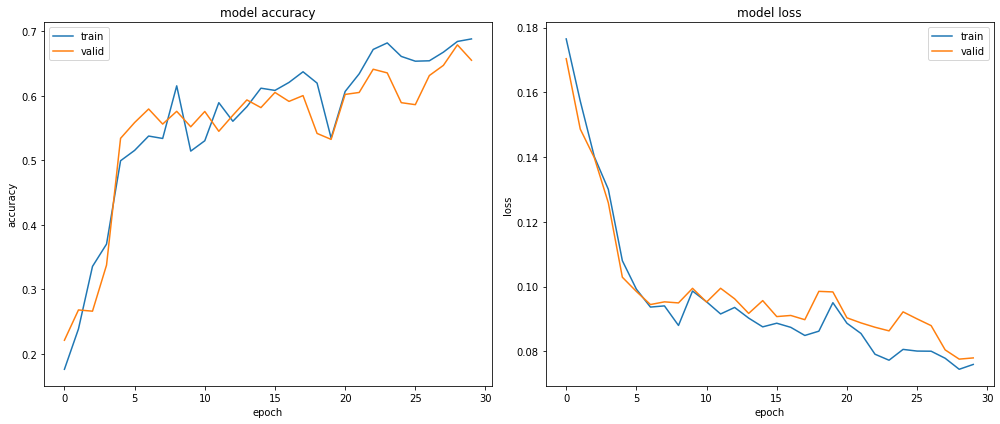

In [22]:
# Show history

show_graph_loss_accuracy(np.asarray(history),1)

# **13. Evaluating the CNN model over training and validation data**

In [23]:
# Functions

def Test(model, patch_test):
    result = model.predict(patch_test)
    predicted_classes = np.argmax(result, axis=-1)
    return predicted_classes

def compute_metrics(true_labels, predicted_labels):
    accuracy = 100*accuracy_score(true_labels, predicted_labels)
    f1score = 100*f1_score(true_labels, predicted_labels, average=None)
    recall = 100*recall_score(true_labels, predicted_labels, average=None)
    precision = 100*precision_score(true_labels, predicted_labels, average=None)
    return accuracy, f1score, recall, precision

In [24]:
# load the best model (.h5 file)
model = load_model(root_path + best_model_filename + '.h5', compile=False)

# Test the model over training and validation data
pred_train = Test(model, x_train)
pred_valid = Test(model, x_valid)


Plotting images...


(-0.5, 255.5, 255.5, -0.5)

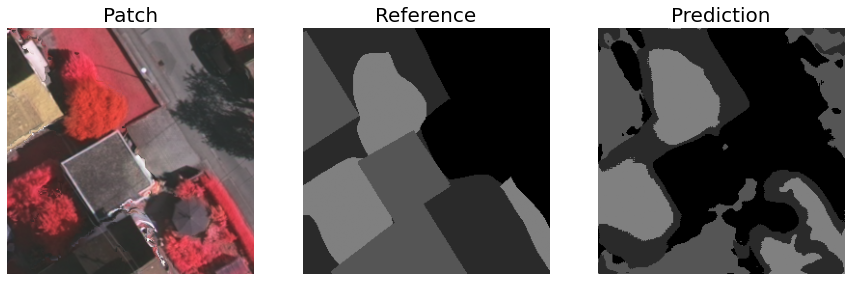

In [25]:
# Showing the prediction for an arbitrary training patch

index = 20

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow(x_train[index])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( y_train[index, :, :, 0], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_train[index], cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')

In [26]:
# Showing the confusion matrix and accuracy metrics for the training data

true_labels = np.reshape(y_train, (y_train.shape[0]* y_train.shape[1]*y_train.shape[2]))
predicted_labels = np.reshape(pred_train, (pred_train.shape[0]* pred_train.shape[1]*pred_train.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[1100702  167330  193150   18034       0]
 [ 130800  836427   93773  479578       0]
 [ 304791   51033  801336    2652       0]
 [  37808  368988   11345 1544726       0]
 [  14711    1475    1502     223       0]]

Metrics
Accuracy:  69.52798721638132
F1score:  [71.75306092 56.40422533 70.88589679 77.08059719  0.        ]
Recall:  [74.41117457 54.29306403 69.09188731 78.69743594  0.        ]
Precision:  [69.27830354 58.6862122  72.77555476 75.5288569   0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Showing the confusion matrix and accuracy metrics for the validation data

true_labels = np.reshape(y_valid, (y_valid.shape[0]* y_valid.shape[1]*y_valid.shape[2]))
predicted_labels = np.reshape(pred_valid, (pred_valid.shape[0]* pred_valid.shape[1]*pred_valid.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[210898  42873  57065   5977      0]
 [ 36105 219093  23565 115203      0]
 [ 65695  16918 241099    780      0]
 [  6469  88887   1236 373720      0]
 [  1506    165      1     73      0]]

Metrics
Accuracy:  69.31537130604619
F1score:  [66.16553148 57.51212098 74.47556444 77.36953518  0.        ]
Recall:  [66.56860672 55.61215942 74.300445   79.46214428  0.        ]
Precision:  [65.76730813 59.54649722 74.6515113  75.38431437  0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Freeing up memory

x_train = 0
y_train = 0
x_valid = 0
y_valid = 0
pred_train = 0
pred_valid = 0
true_labels = 0
predicted_labels = 0

# **14. Inference (testing the CNN model)**

In [29]:
# load the best model (.h5 file)
best_model_filename = 'best_CNN_model'
model = load_model(root_path + best_model_filename + '.h5', compile=False)

In [30]:
# Constants

# patch_size defines the measures (spatial dimensions) of the patch.
# Working with square patches (H = W). Therefore, a scalar variable is enough.
patch_test_size = patch_size
patch_test_stride = 128


In [31]:
# Extracting test patches

x_patches_test, y_patches_test = extract_patches(image_test, labels_test, patch_test_size, patch_test_stride, True)

print( "Number of patches: %d %s " % ( x_patches_test.shape[0], x_patches_test.shape[1:] ) )
print( "Number of labeled references: %d %s " % ( y_patches_test.shape[0], y_patches_test.shape[1:] ) )

Image dimensions: (2558, 2818, 3)
Reference dimensions: (2558, 2818)
Number of patches: 418 (256, 256, 3) 
Number of labeled references: 418 (256, 256) 


# **15. Prediction over test patches**

In [32]:
# Test the model over test patches 

pred_test_patches = Test(model, x_patches_test)
print(pred_test_patches.shape)

(418, 256, 256)



Plotting images...


(-0.5, 255.5, 255.5, -0.5)

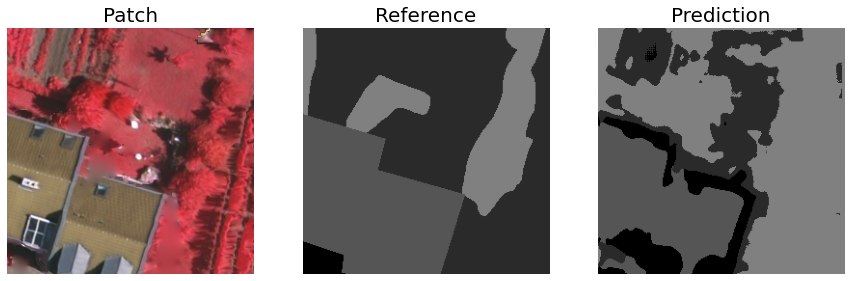

In [33]:
# Showing prediction result for an arbitrary test patch

index = 20

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow(x_patches_test[index])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( y_patches_test[index], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_test_patches[index], cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')


In [34]:
# Showing the confusion matrix and accuracy metrics for the test data (patches)

true_labels = np.reshape(y_patches_test, (y_patches_test.shape[0]* y_patches_test.shape[1]*y_patches_test.shape[2]))
predicted_labels = np.reshape(pred_test_patches, (pred_test_patches.shape[0]* pred_test_patches.shape[1]*pred_test_patches.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[3449770  602149  149046  795803       0]
 [ 952622 3204007  656779 4657260       0]
 [1017087  242669 3593017   19528       0]
 [  81325  730910   10816 7126452       0]
 [  81983    7725   14722     378       0]]

Metrics
Accuracy:  63.419783742804285
F1score:  [65.21578649 44.94288451 77.2967686  69.36082882  0.        ]
Recall:  [69.04002747 33.83084488 73.74374038 89.64650998  0.        ]
Precision:  [61.79297186 66.92498736 81.2095028  56.561742    0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **16. Mosaic of the test patches predictions**

In [35]:
# Assembling mosaic of the test patches predictions

pred_test_mosaic = np.zeros(labels_test.shape)
patch_test_overlap = patch_test_stride/patch_test_size

# Image positions
x = y = 0
xmax, ymax = labels_test.shape 

# Patch positions
pi = patch_test_size//2 - int(patch_test_size*patch_test_overlap**2)
pf = patch_test_size//2 + int(patch_test_size*patch_test_overlap**2)
 
for patch in pred_test_patches:
  if y==0: ypi = 0 
  else: ypi = pi
  if y+pf+patch_test_stride>ymax: ypf = ymax-y-2
  else: ypf = pf
  if x==0: xpi = 0 
  else: xpi = pi
  if x+pf+patch_test_stride>xmax: xpf = xmax-x 
  else: xpf = pf

  pred_test_mosaic[x+xpi:x+xpf,y+ypi:y+ypf] = patch[xpi:xpf,ypi:ypf]

  y += patch_test_stride
  if y+patch_test_stride >= ymax:
    x += patch_test_stride
    y = 0



Plotting images...


(-0.5, 2817.5, 2557.5, -0.5)

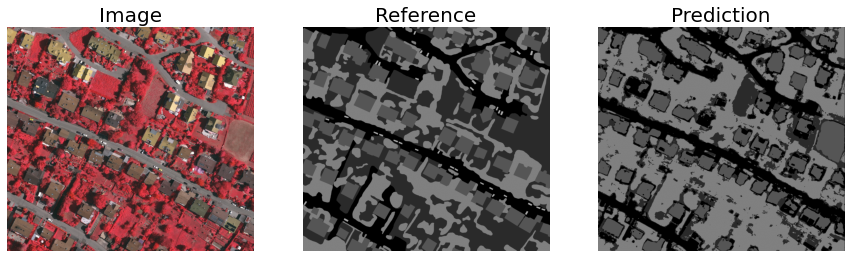

In [36]:
# Showing prediction results mosaic

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow( image_test )
ax1.set_title('Image', fontsize=20)
ax1.axis('off')

ax2.imshow( labels_test, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_test_mosaic, cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')


In [37]:
# Showing the confusion matrix and accuracy metrics for the prediction results mosaic

true_labels = np.reshape(labels_test, (labels_test.shape[0]*labels_test.shape[1]))
predicted_labels = np.reshape(pred_test_mosaic, (pred_test_mosaic.shape[0]*pred_test_mosaic.shape[1]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[ 952010  155998   34109   43107       0]
 [ 275823  839611  162538 1271132       0]
 [ 281069   63613  953158    4928       0]
 [  24685  193153    1214 1925254       0]
 [  21756    2054    3128     104       0]]

Metrics
Accuracy:  64.78559034376906
F1score:  [69.47540418 44.14900567 77.58982301 71.45349335  0.        ]
Recall:  [80.32321316 32.9374949  73.16406298 89.78448039  0.        ]
Precision:  [61.20900663 66.9317275  82.58549388 59.33854724  0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
